In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
base_metadata_pth = Path('/Users/tsakalis/ntua/nestor/nestor_celvia/metadata')

basic_metadata_file = 'metadata.repository.2024-11-05.json'
clinical_cohort_file = 'clinical.cohort.2024-11-07.json'
biospecimen_file = 'biospecimen.cohort.2024-11-07.json'
gene_expr_file = 'Human__TCGA_OV__UNC__RNAseq__GA_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct'
# gene_expr_file = "Human__TCGA_OV__UNC__RNAseq__HiSeq_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct"

gene_mutation_file = 'Human__TCGA_OV__WUSM__Mutation__GAIIx__01_28_2016__BI__Gene__Firehose_MutSig2CV.cbt'

In [ ]:
gene_names = pd.read_csv(base_metadata_pth / 'GeneNames.tsv', header=None)

In [ ]:
metadata_df = pd.read_json(base_metadata_pth / basic_metadata_file)

clinical_cohort_df = pd.read_json(base_metadata_pth / clinical_cohort_file)

biospecimen_df = pd.read_json(base_metadata_pth / biospecimen_file)
gene_expr_df = pd.read_csv(base_metadata_pth / gene_expr_file, delimiter='\t')

gene_mutation_df = pd.read_csv(base_metadata_pth / gene_mutation_file,
                               delimiter='\t')

In [ ]:
latent_vec_pth = Path(
    '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/latent_vectors'
)

In [ ]:
import torch

In [ ]:
import h5py
import pandas as pd


def load_h5(path, key='mean'):
    """
    Load data from an HDF5 file and return the specified dataset as a DataFrame.

    Parameters:
    - path (str): Path to the HDF5 file.
    - key (str): Key of the dataset to retrieve.

    Returns:
    - pd.DataFrame: DataFrame containing the data from the specified key.
    """
    with h5py.File(path, "r") as f:
        if key not in f:
            raise KeyError(f"Key '{key}' not found in the HDF5 file.")

        ds_arr = f[key][()]  # Get the numpy array from the specified key

    # Return the data as a DataFrame
    return pd.DataFrame(ds_arr)


In [ ]:
latent_vec_pth = Path(
    '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/embeddings_adco'
)
latent_vecs = [(pth.stem, load_h5(pth), load_h5(pth, key='max'),
                load_h5(pth, key='min'), load_h5(pth, key='std'))
               for pth in latent_vec_pth.glob('*.h5')]

# latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [ ]:
# latent_vec_pth = Path(
#     '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/embeddings_adco'
# )
# latent_vecs = [(pth.stem, torch.load(pth,
#                                      map_location=torch.device('cpu')).numpy())
#                for pth in latent_vec_pth.glob('*.pt')]

# # latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [ ]:
test_id = "TCGA-WR-A838-01A-01-TS1.E8CA96CD-A253-4090-86BA-60E7192B72FD"

In [ ]:
all_latent_df = []

for latent in latent_vecs:
    latent_df_mean = pd.DataFrame(latent[1]).transpose()
    latent_df_max = pd.DataFrame(latent[2]).transpose()

    latent_df_min = pd.DataFrame(latent[3]).transpose()
    latent_df_std = pd.DataFrame(latent[4]).transpose()
    latent_df = pd.concat(
        [latent_df_mean, latent_df_max, latent_df_min, latent_df_std], axis=1)
    # break
    latent_df.columns = [f"emb_{i}" for i in range(4096)]
    latent_df['file_name'] = latent[0] + ".svs"  #.split('_')[0]
    if test_id == latent[0]:
        break
    all_latent_df.append(latent_df)

In [ ]:
pd.concat([latent_df_mean, latent_df_max], axis=1)

In [ ]:
latent_vec_pth = Path(
    '/Users/tsakalis/ntua/nestor/nestor_celvia/src/vae_embeddings/latent_vectors'
)

latent_vecs2 = [(pth.stem, np.load(pth))
                for pth in latent_vec_pth.glob('*.npy')]

# latent_vecs = [np.load(pth) for pth in latent_vec_pth.glob('*.npy')]

In [ ]:
metadata_df['submitter_id'] = metadata_df.submitter_id.apply(
    lambda x: '.'.join(x.split('-')[:3]))

In [ ]:
merged_genes = pd.merge(gene_expr_df.set_index('attrib_name'),
                        gene_names,
                        left_index=True,
                        right_on=0)


In [ ]:
clinical_cohort_df['submitter_id'] = clinical_cohort_df['submitter_id'].apply(
    lambda x: x.replace('-', '.'))

In [ ]:
gene_patient = pd.merge(metadata_df,
                        merged_genes.T,
                        left_on='submitter_id',
                        right_index=True)

In [ ]:
metadata_latent = pd.merge(metadata_df,
                           pd.concat(all_latent_df),
                           on='file_name')

In [ ]:
all_data = pd.merge(metadata_latent,
                    gene_patient.reset_index(drop=True),
                    on='file_id',
                    how='inner')

In [ ]:
gene_patient.file_name


In [ ]:
# Get unique values of the stratify column
from sklearn.model_selection import train_test_split

unique_values = all_data['submitter_id_x'].unique()

# Split unique values into train and test
train_ids, test_ids = train_test_split(all_data.index,
                                       test_size=0.2,
                                       random_state=42)

In [ ]:
target_labels = all_data.columns[-35:]

In [ ]:
genes_ovarian_cancer = [
    "BRCA1", "BRCA2", "TP53", "RAD51C", "RAD51D", "PALB2", "ATM", "CHEK2",
    "PTEN", "ARID1A"
]


In [ ]:
input_labels = [f"emb_{i}" for i in range(1024 * 4)]

In [ ]:
from sklearn.preprocessing import LabelEncoder

encode_p = LabelEncoder().fit_transform(all_data['submitter_id_x'])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, accuracy_score, f1_score, classification_report, r2_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

In [ ]:
# pca = PCA(n_components=700)

# pcaed = pca.fit_transform(all_data[input_labels])

# all_data_copy = all_data.copy()


In [ ]:
train_data = all_data.loc[train_ids]
test_data = all_data.loc[test_ids]

In [129]:
X_train, X_test, y_train, y_test = train_data[input_labels], test_data[
    input_labels], train_data[target_labels], test_data[target_labels]

In [130]:
# for i in range(len(target_labels)):
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)
model.fit(X_train, y_train.values.astype(float))

# Make predictions
y_pred = model.predict(X_test)
# print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
print(r2_score(y_test, y_pred))

0.03840318582153416


In [131]:
y_test.shape

(141, 35)

In [135]:
best_feats_idx = np.argsort(model.feature_importances_, )[-1500:]

In [149]:
num_feats = 1500

In [150]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesRegressor

rfe_selector = RFE(estimator=RandomForestRegressor(n_jobs=-1),
                   n_features_to_select=num_feats,
                   step=500,
                   verbose=5)
rfe_selector.fit(X_train, y_train)
rfe_support = rfe_selector.get_support()
# rfe_feature = X[corrs.dropna().index].loc[:,rfe_support].columns.tolist()
# print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 4096 features.
Fitting estimator with 3596 features.
Fitting estimator with 3096 features.
Fitting estimator with 2596 features.
Fitting estimator with 2096 features.
Fitting estimator with 1596 features.


In [151]:
rfe_selector.__dict__


{'estimator': RandomForestRegressor(n_jobs=-1),
 'n_features_to_select': 1500,
 'step': 500,
 'importance_getter': 'auto',
 'verbose': 5,
 'feature_names_in_': array(['emb_0', 'emb_1', 'emb_2', ..., 'emb_4093', 'emb_4094', 'emb_4095'],
       dtype=object),
 'n_features_in_': 4096,
 'estimator_': RandomForestRegressor(n_jobs=-1),
 'n_features_': 1500,
 'support_': array([False,  True,  True, ...,  True, False, False]),
 'ranking_': array([7, 1, 1, ..., 1, 5, 3])}

In [152]:
rfe_support.sum()

1500

In [153]:
params_opt = {
    'n_estimators': 800,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    # 'max_features': 'sqrt'
    'max_depth': 15,
    'random_state': 42
}

In [154]:
# for i in range(len(target_labels)):
model2 = RandomForestRegressor(n_jobs=-1, **params_opt)
model2.fit(X_train.iloc[:, rfe_support], y_train.values.astype(float))

# Make predictions
y_pred = model2.predict(X_test.iloc[:, rfe_support])
# print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
print(r2_score(y_test, y_pred))

0.04652231685555213


In [ ]:
RandomForestRegressor?

Init signature:
RandomForestRegressor(
    n_estimators=100,
    *,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
    monotonic_cst=None,
)
Docstring:     
A random forest regressor.

A random forest is a meta estimator that fits a number of decision tree
regressors on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
Trees in the forest use the best split strategy, i.e. equivalent to passing
`splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeRegressor`.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is use

In [ ]:
# from catboost import CatBoostRegressor

# cb_reg = CatBoostRegressor(
#     objective='MultiRMSE',
#     verbose=0,
#     learning_rate=0.1,
#     n_estimators=10,
#     #    num_boost_round=10
# )
# cb_reg.fit(X_train.values, y_train)
# cb_pred = cb_reg.predict(X_test)
# # pd.DataFrame(cb_pred, columns=['Y1', 'Y2'])

In [ ]:
CatBoostRegressor?

Init signature:
CatBoostRegressor(
    iterations=None,
    learning_rate=None,
    depth=None,
    l2_leaf_reg=None,
    model_size_reg=None,
    rsm=None,
    loss_function='RMSE',
    border_count=None,
    feature_border_type=None,
    per_float_feature_quantization=None,
    input_borders=None,
    output_borders=None,
    fold_permutation_block=None,
    od_pval=None,
    od_wait=None,
    od_type=None,
    nan_mode=None,
    counter_calc_method=None,
    leaf_estimation_iterations=None,
    leaf_estimation_method=None,
    thread_count=None,
    random_seed=None,
    use_best_model=None,
    best_model_min_trees=None,
    verbose=None,
    silent=None,
    logging_level=None,
    metric_period=None,
    ctr_leaf_count_limit=None,
    store_all_simple_ctr=None,
    max_ctr_complexity=None,
    has_time=None,
    allow_const_label=None,
    target_border=None,
    one_hot_max_size=None,
    random_strength=None,
    random_score_type=None,
    name=None,
    ignored_features=None,

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 150, 200, 500, 800],
    'max_depth': [None, 10, 15, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['sqrt']
    # 'max_features': [None, 'sqrt', 'log2']
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# RandomizedSearchCV for lightweight optimization
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=40,  # Number of parameter settings to sample
    cv=3,  # Number of folds for cross-validation
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=7)

# Fit the random search to the data
random_search.fit(X_train.iloc[:, best_feats_idx],
                  y_train.values)  # Flatten y_train for regression

# Best parameters and evaluation
best_model = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

# Evaluate the best model
y_pred = best_model.predict(X_test.iloc[:, best_feats_idx])
print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best Parameters: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15}
R2 Score: 0.048403477817215115
Mean Squared Error: 0.3238247359638796


In [ ]:
y_train.shape

(564, 35)

In [77]:
y_pred_flat.shape

NameError: name 'y_pred_flat' is not defined

In [78]:
# import lightgbm as lgb
# from sklearn.metrics import r2_score
# import numpy as np

# correls = []
# # Assuming y_train and y_test are numpy arrays with shape (n_samples, n_targets)
# for i in range(y_train.shape[1]):  # Loop over each target variable
#     # Prepare the LightGBM dataset
#     train_data = lgb.Dataset(X_train, label=y_train.values[:, i])
#     test_data = lgb.Dataset(X_test,
#                             label=y_test.values[:, i],
#                             reference=train_data)

#     # Set parameters
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'boosting_type': 'gbdt',
#         'n_jobs': -1,
#         'verbosity': -1,
#         # 'num_leaves': 500,  # Large number of leaves to increase complexity
#         # 'max_depth': -1,  # No depth limit
#         # 'min_data_in_leaf': 1,  # Allow very small leaves
#         # 'min_child_samples': 1,  # Reduce the minimum data per child
#         # 'lambda_l1': 0,  # No L1 regularization
#         # 'lambda_l2': 0,  # No L2 regularization
#         # 'learning_rate': 0.1,  # Larger learning rate for faster overfitting
#         # 'feature_fraction': 1.0,  # Use all features
#         # 'bagging_fraction': 1.0,  # Use all data
#         # 'bagging_freq': 0,  # No bagging
#     }

#     # Train the model
#     model = lgb.train(
#         params,
#         train_data,
#         num_boost_round=100,
#         valid_sets=[train_data, test_data],
#         valid_names=['train', 'valid'],
#         #   early_stopping_rounds=10,
#         # verbose_eval=False
#     )

#     # Make predictions
#     y_pred = model.predict(X_test)

#     # Evaluate the model
#     r2 = r2_score(y_test.values[:, i], y_pred)
#     print(f"R2 score for target {i}: {r2}")
#     print(
#         np.corrcoef(y_test.values[:, i].flatten().astype(float),
#                     y_pred.flatten()))

#     correls.append(
#         np.corrcoef(y_test.values[:, i].flatten().astype(float),
#                     y_pred.flatten()))


In [157]:
correls = []
for i in range(len(target_labels)):
    correls.append(
        np.corrcoef(y_test.values[:, i].flatten().astype(float),
                    y_pred[:, i].flatten())[0, 1])

In [158]:
sorted(correls)[::-1]

[0.5388978520768224,
 0.4941210796726394,
 0.44734903367064555,
 0.42215668172767,
 0.37965028972244586,
 0.36075825894721403,
 0.35880792394103095,
 0.27436376682462005,
 0.2687057123370865,
 0.26644803677346024,
 0.2659866225516097,
 0.2659859467572564,
 0.2629317854579383,
 0.25901905434156164,
 0.25427036163723804,
 0.24949714378205576,
 0.24946090230997456,
 0.22862407074149022,
 0.21959791051462144,
 0.21734685815432253,
 0.21731108902774832,
 0.2086914017884861,
 0.19608599616771757,
 0.19434215944292896,
 0.16726135807883127,
 0.1653287830436529,
 0.16437600084157575,
 0.14886546145957222,
 0.1482927909500005,
 0.10933207704108251,
 0.043427076090790134,
 0.03878518980477189,
 0.006969840830346655,
 -0.004430656121665212,
 -0.07332714626675654]

In [159]:
# for i in range(len(target_labels)):
#     model = RandomForestRegressor()
#     model.fit(X_train, y_train.values[:, i])

#     # Make predictions
#     y_pred = model.predict(X_test)
#     # print(mean_squared_error(y_test.flatten(), y_pred.flatten()))
#     print(r2_score(y_test.values[:, i], y_pred))
#     print(
#         np.corrcoef(y_test.values[:, i].flatten().astype(float),
#                     y_pred.flatten())[0, 1])

In [160]:
y_test.values.flatten()

array([7.3794, 5.4406, 8.0799, ..., 5.8236, 7.6567, 7.558], dtype=object)

In [161]:
y_pred.flatten()

array([7.02046532, 5.39503005, 7.88716242, ..., 6.56485879, 7.79559888,
       7.09900303])

In [162]:
y_test.shape

(141, 35)

In [163]:
def find_vector_duplicates(array1, array2):
    # Convert each vector to a tuple for hashable comparison
    set1 = {tuple(vec) for vec in array1}
    duplicates = [vec for vec in array2 if tuple(vec) in set1]
    return duplicates

In [164]:
gene_names.iloc[genes][0].values

array(['FGFR2', 'PPP2R1A', 'RNF43', 'EGFR', 'ERBB4', 'RAC1', 'EZH2',
       'MYCN', 'TOP1', 'GNAQ', 'PTCH1', 'MYD88', 'MAPK1', 'BRAF',
       'NOTCH2', 'CDK6', 'TSC2', 'NTRK1', 'AKT2', 'NFE2L2', 'CBL',
       'CHEK2', 'ATM', 'BTK', 'CREBBP', 'MYC', 'MAGOH', 'PDGFRA', 'DDR2',
       'NOTCH3', 'ARID1A', 'GNA11', 'HRAS', 'SMARCB1', 'MAP2K2'],
      dtype=object)

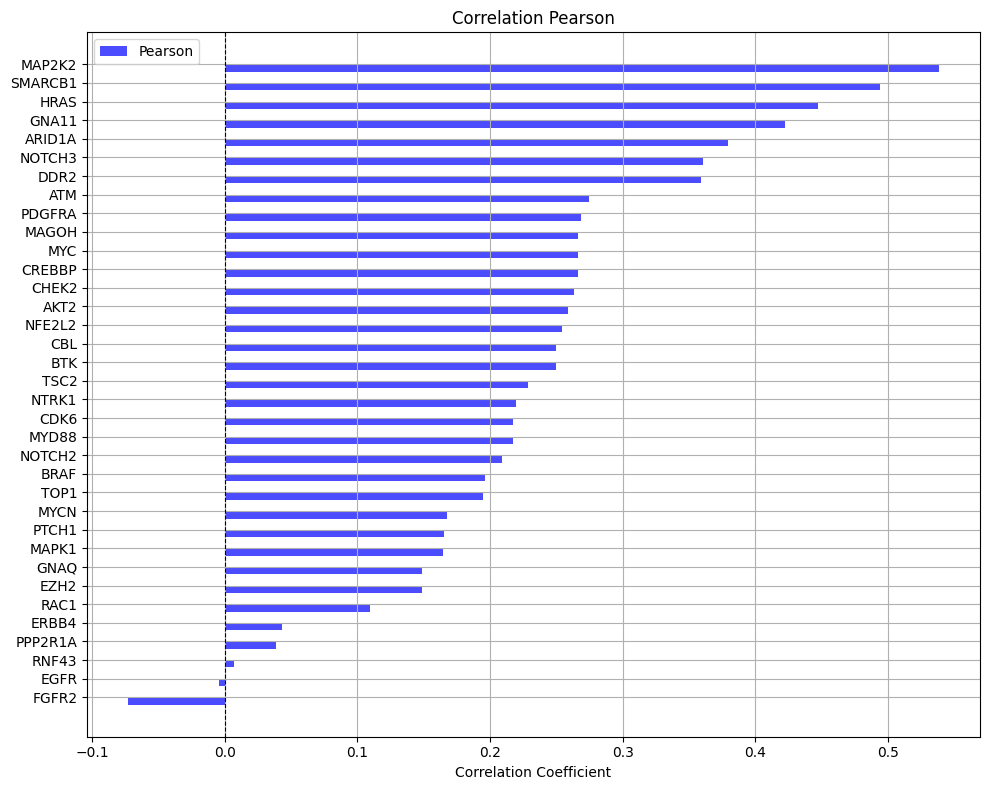

In [165]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the plot (example data, replace with actual values)
sort_idx = np.argsort(correls)  #[::-1]
genes = np.array(target_labels)[sort_idx]

# Plotting
y_pos = np.arange(len(genes))

plt.figure(figsize=(10, 8))
plt.barh(y_pos - 0.2,
         np.array(correls)[sort_idx],
         height=0.4,
         label='Pearson',
         color='blue',
         alpha=0.7)
# plt.barh(y_pos + 0.2, spearman, height=0.4, label='Spearman', color='orange', alpha=0.7)

plt.yticks(y_pos, gene_names.iloc[genes][0].values)
plt.xlabel("Correlation Coefficient")
plt.title("Correlation Pearson")
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()


In [ ]:
y_test.shape

In [ ]:
np.corrcoef(y_test.T, y_pred.T)

In [ ]:
pca_vecs = pca.fit_transform(latent_vecs)

In [ ]:
pca.explained_variance_ratio_.sum()

In [ ]:
pca.get_covariance()

In [ ]:
np.corrcoef(pca_vecs[:, 0], [pca_vecs[:, 1]])

In [ ]:
plt.scatter(pca_vecs[:, 0], [pca_vecs[:, 1]])
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)